In [115]:
from htc_class_testing import HolsteinTavisCummings
import numpy as np
from qutip import *
from qutip.core.gates import *
from numpy import array
from numpy import real
import matplotlib.pyplot as plt
pi = np.pi
import json 
LiH_params = {
    'w_q1': 0.12086,         # Qubit 1 frequency in a.u.
    'w_q2': 0.12086,         # Qubit 2 frequency
    'w_vib1': 0.00622913,       # Vibrational mode 1 frequency
    'w_vib2': 0.00622913,      # Vibrational mode 2 frequency
    'w_cav': 0.12086,        # Cavity frequency
    'S_1':  10.5615447,         # Huang-Rhys factor for qubit 1 and vib 1
    'S_2': 10.5615447,         # Huang-Rhys factor for qubit 2 and vib 2
    'lambda_1': 0.05,     # Cavity coupling strength for qubit 1
    'lambda_2': 0.05,    # Cavity coupling strength for qubit 2
    'N_vib': 2,         # Number of vibrational states to include
    'N_cav': 2,          # Cavity truncation level
    'qubit_1_dipole_moments' : 
    { 
        'mu_g': -2.354965266795868, #ground dipole moment
        'mu_e': 2.0510843691207983, #excited dipole moment
        'mu_eg': 1.0338263686725813 #transition dipole moment
    },
    'qubit_2_dipole_moments' : 
    { 
        'mu_g': -2.354965266795868, #ground dipole moment
        'mu_e': 2.0510843691207983, #excited dipole moment
        'mu_eg': 1.0338263686725813 #transition dipole moment
    }
}

import json

#def write_dict_to_json(data: dict, filename: str) -> None:
#    """
#    Writes a dictionary to a JSON file.
#    
#    Parameters:
#    - data (dict): Dictionary to be written.
#    - filename (str): Path to the output JSON file.
##    """
#    with open(filename, 'w') as f:
#        json.dump(data, f, indent=4)  # indent for readability

#write_dict_to_json(LiH_params, 'LiH_params.json')

# local qubit operators
sz = sigmaz()
sm = destroy(2)
sp = sm.dag()
# qubit number operator
nq = sp * sm

# local cavity/vibration operators
am = destroy(2)
ap = am.dag()
# local cavity number operator, also works for local vibrations
nc = ap * am

# identities
Iq = qeye(2)
Ic = qeye(2)
Iv = qeye(2)

# frequencies
omega_q = LiH_params["w_q1"]
omega_c = LiH_params["w_cav"]
omega_v = LiH_params["w_vib1"]

# qubit transition dipole moment
mu_eg = LiH_params["qubit_1_dipole_moments"]["mu_eg"]

# field-squared dipole moment
d_eg = LiH_params["lambda_1"] * mu_eg

# qubit-cavity coupling 
g = -np.sqrt(omega_c / 2 ) * d_eg

print("G is ", g)
# qubit-vib coupling strength
lambda_v = omega_v * np.sqrt(0.5) # np.sqrt(LiH_params["S_1"])
print("lambda_v is ", lambda_v)

# local qubit 1 Hamiltonian
H_q1_local = -omega_q / 2 * sz

# local qubit 2 Hamiltonian
H_q2_local = -omega_q / 2 * sz

# local qubit 1 vibration
H_v1_local = omega_v * nc

# local qubit 2 vibration
H_v2_local = omega_v * nc

# local cavity Hamiltonian
H_cav_local = omega_q * nc

# bare Hamiltonians in composite space
H_q1 = tensor(H_q1_local, Iq, Iv, Iv, Ic)
H_q2 = tensor(Iq, H_q2_local, Iv, Iv, Ic)

H_v1 = tensor(Iq, Iq, H_v1_local, Iv, Ic)
H_v2 = tensor(Iq, Iq, Iv, H_v2_local, Ic)

H_cav = tensor(Iq, Iq, Iv, Iv, H_cav_local)

# define H_bare_total as the sum of the three bare Hamiltonians for qubit 1, qubit 2, and cavity
# all on the composite space
H_bare_total = H_q1 + H_q2 + H_v1 + H_v2 + H_cav 

# qubit1 - cavity interaction in order q1 x q2 x cav
H_q1_cav = g * tensor(sp, Iq, Iv, Iv, am) + g * tensor(sm, Iq, Iv, Iv, ap)
H_q2_cav = g * tensor(Iq, sp, Iv, Iv, am) + g * tensor(Iq, sm, Iv, Iv, ap)

# qubit1 - vibration interaction in order q1 x q2 x vib1 x vib2 x cav
H_q1_vib1 = lambda_v * tensor(sp * sm, Iq, (am + ap), Iv, Ic)
H_q2_vib2 = lambda_v * tensor(Iq, sp * sm, Iv, (am + ap), Ic)


# H_bare_total + vibronic coupling
H_bare_vc = H_bare_total + H_q1_vib1 + H_q2_vib2

tlist = np.linspace(0, 2*1400, 2*5000)



G is  -0.012707025647924667
lambda_v is  0.004404660063892559


In [116]:
# resonant SQRT iSWAP gate
T0_1 = 20
g_eff = g #* np.exp(-np.sqrt(0.5) / 2.0)
T_gate_1 = (1*pi)/(4 * np.abs(g_eff))

# resonant iSWAP gate
T0_2 = T0_1 + T_gate_1
T_gate_2 = (2 *pi)/(4 * np.abs(g_eff)) 

print(T_gate_1)
print(T_gate_2)

61.8081827454028
123.6163654908056


In [117]:
def wc_t(t, args=None):
    return 1

def w1_t(t, args=None):
    if t > T0_1 and t <= T0_1 + T_gate_1:
        return 1
    else:
        return 0

def w2_t(t, args=None):
    if t > T0_2 and t <= T0_2 + T_gate_2:
        return 1
    else:
        return 0



In [118]:
# time-dependent H; H_q1 + H_q2 + H_cav on at all times, H_q1_cav on until T1, H_q2_cav on from T1 to T1+T2
H_t = [[H_bare_vc, wc_t], [H_q1_cav, w1_t], [H_q2_cav, w2_t]]

# operators in composite space for expectation values
nq1  = tensor(nq, Iq, Iv, Iv, Ic)
nq2  = tensor(Iq, nq, Iv, Iv, Ic)
ncav = tensor(Iq, Iq, Iv, Iv, nc)

In [119]:
psi0 = tensor( basis(2,1), basis(2,0),basis(2,0), basis(2,0), basis(2,0))

In [120]:
psi0

Quantum object: dims=[[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape=(32, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [121]:
res = mesolve(H_t, psi0, tlist, [], e_ops=[])

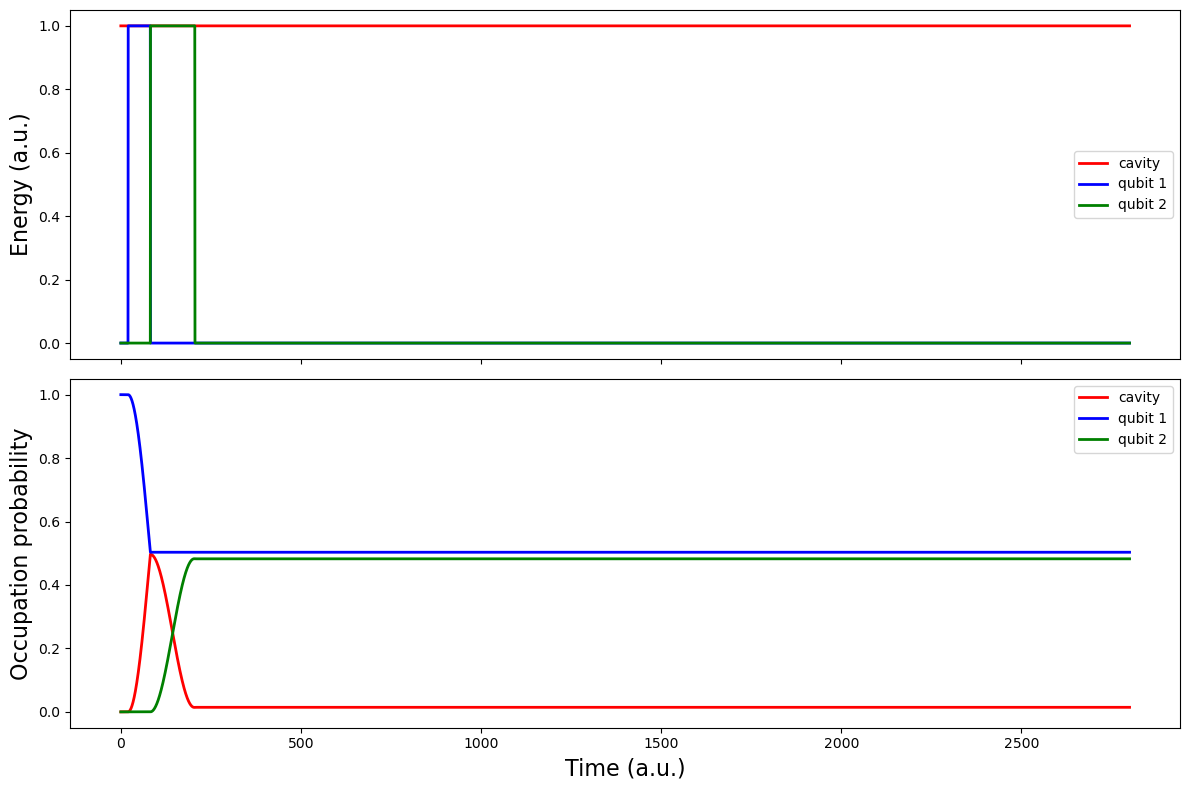

In [122]:
from numpy import real
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))), 'g', linewidth=2, label="qubit 2")
#axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (a.u.)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(ncav, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(nq1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(nq2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_xlabel("Time (a.u.)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

In [123]:
rho_final = res.states[-1]
rho_final

Quantum object: dims=[[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape=(32, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00+0.j        ]
 [ 2.24531521e-03+0.01575568j]
 [ 0.00000000e+00+0.j        ]
 [ 7.76468570e-02-0.08581778j]
 [ 0.00000000e+00+0.j        ]
 [ 4.74608905e-04+0.00357174j]
 [ 0.00000000e+00+0.j        ]
 [ 1.77604728e-02-0.019263j  ]
 [-4.08708786e-01+0.03768319j]
 [ 0.00000000e+00+0.j        ]
 [ 4.93990679e-01-0.21550983j]
 [ 0.00000000e+00+0.j        ]
 [-9.26140103e-02+0.00765774j]
 [ 0.00000000e+00+0.j        ]
 [ 1.12286892e-01-0.04773868j]
 [ 0.00000000e+00+0.j        ]
 [ 6.01173754e-01+0.21266551j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-1.90437189e-01+0.24554671j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j   

In [124]:
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [0,1])
rho_qubits

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.01434649+0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.4824575 +0.j         -0.2181736 +0.13085516j
   0.        +0.j        ]
 [ 0.        +0.j         -0.2181736 -0.13085516j  0.50319601+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]]

In [125]:
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))


In [126]:
fidelity(rho_qubits, rho_qubits_ideal)

np.float64(0.8432083789794019)

In [93]:
concurrence(rho_qubits)

np.float64(0.5312461197674232)

In [68]:
# rho_q_cav = ptrace(rho_final, [0,4])
# fid1 = fidelity(rho_q_cav, rho

In [ ]:
# test = system.H_cav.eigenenergies().tolist()
# test.sort()
# test

In [14]:


fid_data = np.array([
    [0.0000, 1.0000000000, 0.9999999937],
    [0.1000, 0.9560588735, 0.9123191161],
    [0.2000, 0.9002483797, 0.8374089678],
    [0.3000, 0.8096217850, 0.6867068736],
    [0.4000, 0.7082383063, 0.6030696897],
    [0.5000, 0.6317772776, 0.6196607842],
    [0.6000, 0.5978952700, 0.6274098702],
    [0.7000, 0.5949017889, 0.5707803172],
    [0.8000, 0.5976894839, 0.4566930967],
    [0.9000, 0.5883310061, 0.3222956962],
    [1.0000, 0.5615936563, 0.2348917956],
    [1.1000, 0.5223013194, 0.2546278767],
    [1.2000, 0.4813117127, 0.3225396428],
    [1.3000, 0.4518933370, 0.3736938853],
    [1.4000, 0.4440390435, 0.3909695333],
    [1.5000, 0.4590942827, 0.3750705832],
    [1.6000, 0.4899042310, 0.3305513938],
    [1.7000, 0.5265181802, 0.2621351724],
    [1.8000, 0.5608429474, 0.1765422745],
    [1.9000, 0.5881326356, 0.0880720350],
    [2.0000, 0.6065765194, 0.0662810587],
    [2.1000, 0.6165270314, 0.1368405944],
    [2.2000, 0.6197278250, 0.2033078268],
    [2.3000, 0.6186414179, 0.2463729302],
    [2.4000, 0.6158465257, 0.2621968191],
    [2.5000, 0.6135369419, 0.2525354810],
    [2.6000, 0.6131557335, 0.2227869490],
    [2.7000, 0.6152166701, 0.1804394627],
    [2.8000, 0.6194308305, 0.1334323357],
    [2.9000, 0.6249050279, 0.0888807372],
    [3.0000, 0.6305323997, 0.0521528717],
    [3.1000, 0.6352835221, 0.0263204271],
    [3.2000, 0.6383891580, 0.0128547196],
    [3.3000, 0.6394904283, 0.0119111567],
    [3.4000, 0.6386336199, 0.0190569682],
    [3.5000, 0.6362097546, 0.0308386357],
    [3.6000, 0.6329065455, 0.0447791457],
    [3.7000, 0.6295131335, 0.0582938526],
    [3.8000, 0.6268136057, 0.0693437526],
    [3.9000, 0.6254869186, 0.0766180782],
    [4.0000, 0.6260355782, 0.0794779788],
    [4.1000, 0.6285575111, 0.0781602585],
    [4.2000, 0.6329457868, 0.0732123566],
    [4.3000, 0.6388191734, 0.0655019903],
    [4.4000, 0.6456266587, 0.0559598944],
    [4.5000, 0.6527531115, 0.0455395557],
    [4.6000, 0.6595763570, 0.0350140317],
    [4.7000, 0.6655782354, 0.0251063409],
    [4.8000, 0.6703602334, 0.0164804513],
    [4.9000, 0.6736822341, 0.0100367762],
    [5.0000, 0.6754702016, 0.0075843224],
    [5.1000, 0.6757939649, 0.0094794913],
    [5.2000, 0.6748781394, 0.0130588150],
    [5.3000, 0.6730213356, 0.0174723766],
    [5.4000, 0.6706155316, 0.0230365047],
    [5.5000, 0.6680659798, 0.0300299897],
    [5.6000, 0.6657751591, 0.0383271242],
    [5.7000, 0.6640837034, 0.0474754179],
    [5.8000, 0.6632659584, 0.0568615512],
    [5.9000, 0.6634808215, 0.0658201918],
    [6.0000, 0.6648181526, 0.0736537528],
    [6.1000, 0.6671934187, 0.0798766976],
    [6.2000, 0.6704737669, 0.0840683445],
    [6.3000, 0.6744421090, 0.0860003956],
    [6.4000, 0.6788219808, 0.0855712022],
    [6.5000, 0.6833360407, 0.0828639775],
    [6.6000, 0.6877021511, 0.0781011957],
    [6.7000, 0.6916628976, 0.0715753183],
    [6.8000, 0.6950105344, 0.0636633360],
    [6.9000, 0.6975763161, 0.0547227296],
    [7.0000, 0.6992640394, 0.0451265057],
    [7.1000, 0.7000275052, 0.0352002056],
    [7.2000, 0.6998801775, 0.0252619524],
    [7.3000, 0.6988913407, 0.0157810229],
    [7.4000, 0.6971591380, 0.0084134421],
    [7.5000, 0.6948346547, 0.0097675810],
    [7.6000, 0.6920873494, 0.0174991476],
    [7.7000, 0.6890916257, 0.0260994962],
    [7.8000, 0.6860547873, 0.0344323281],
    [7.9000, 0.6830893365, 0.0423124663],
    [8.0000, 0.6804156441, 0.0493533372],
    [8.1000, 0.6781506899, 0.0553963306],
    [8.2000, 0.6763993562, 0.0602611871],
    [8.3000, 0.6752188353, 0.0638260819],
    [8.4000, 0.6746527862, 0.0659786773],
    [8.5000, 0.6746989636, 0.0666746570],
    [8.6000, 0.6753336512, 0.0659115221],
    [8.7000, 0.6764908833, 0.0637877726],
    [8.8000, 0.6780997548, 0.0604187840],
    [8.9000, 0.6800684718, 0.0559873277],
    [9.0000, 0.6822990436, 0.0507145520],
    [9.1000, 0.6846903552, 0.0448402077],
    [9.2000, 0.6871422819, 0.0386597460],
    [9.3000, 0.6895719525, 0.0324155474],
    [9.4000, 0.6919000611, 0.0263839809],
    [9.5000, 0.6940606675, 0.0208326028],
    [9.6000, 0.6960032227, 0.0160219880],
    [9.7000, 0.6976922231, 0.0122042555],
    [9.8000, 0.6991013449, 0.0096057781],
    [9.9000, 0.7002272906, 0.0082146041],
    [10.0000, 0.7010692923, 0.0076739636],
    [10.1000, 0.7016378017, 0.0074141556],
    [10.2000, 0.7019570176, 0.0070447762],
    [10.3000, 0.7020501277, 0.0064328810],
    [10.4000, 0.7019494273, 0.0056791507]
])


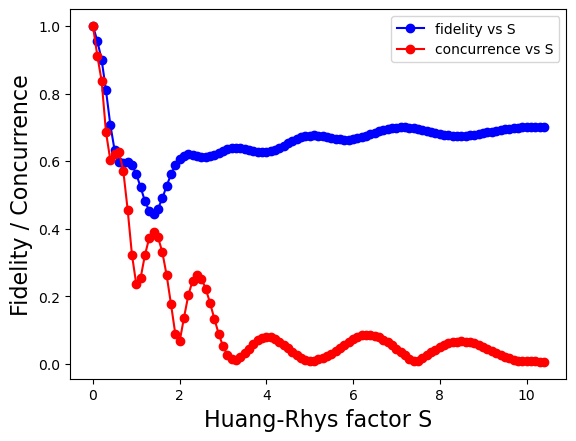

In [16]:
plt.plot(fid_data[:,0], fid_data[:,1], 'bo-', label='fidelity vs S')
plt.plot(fid_data[:,0], fid_data[:,2], 'ro-', label='concurrence vs S')
plt.xlabel('Huang-Rhys factor S', fontsize=16)
plt.ylabel('Fidelity / Concurrence', fontsize=16)
plt.legend()
plt.show()